In [165]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

sns.set_theme()

# EDA

In [166]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [167]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [168]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [170]:
df.duplicated().values.any()

np.False_

In [171]:
df.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [172]:
# Función para calcular la distancia del viaje en base a las coordenadas 
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radio de la Tierra en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


In [173]:
# Función para asignar la franja horaria
def obtener_franja_horaria(hora):
    if 0 <= hora <= 5:
        return 'Madrugada'
    elif 6 <= hora <= 9:
        return 'Mañana'
    elif 10 <= hora <= 15:
        return 'Mediodia/Tarde'
    elif 16 <= hora <= 19:
        return 'Tarde'
    else:
        return 'Noche'

In [174]:
def obtener_semana_mes(fecha):
    return min(int(np.ceil(fecha.day / 7)), 4)

In [175]:
# Creación de copia del df para evitar conflictos.
df_copy = df.copy()

In [176]:
df_copy.isna().sum()

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [177]:
# Drop de unica fila Nan
df_copy.dropna(inplace=True)

Se aprecian valores atípicos muy alejados de la media de los datos y valores negativos imposibles.

<Axes: ylabel='fare_amount'>

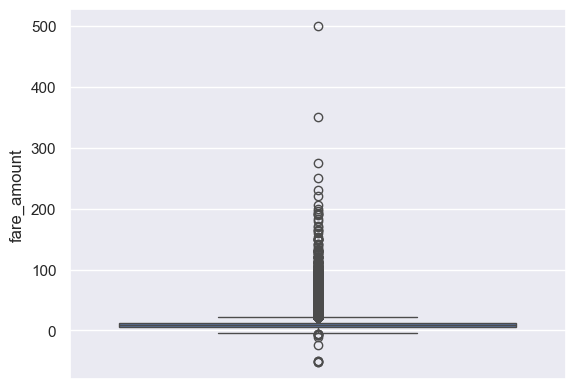

In [178]:
sns.boxplot(df_copy["fare_amount"])

In [179]:
# Eliminación de único valor atípico en la cantidad de pasajeros 
df_copy = df_copy[df_copy["passenger_count"] < 7]

In [180]:
# Filas con precios atípicos
df_copy[df_copy["fare_amount"] > 250]

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
4292,33491441,2014-10-24 20:20:00.000000181,350.0,2014-10-24 20:20:00 UTC,0.000000,0.000000,0.000000,0.0000,3
170081,51151143,2011-04-10 04:10:00.00000064,499.0,2011-04-10 04:10:00 UTC,-73.968377,40.764602,-73.968368,40.7646,1
185325,20013003,2013-04-19 00:00:00.000000235,275.0,2013-04-19 00:00:00 UTC,0.000000,0.000000,0.000000,0.0000,1


In [181]:
df_copy = df_copy[df_copy["fare_amount"] < 250] 

In [182]:
df_copy["fare_amount"].describe()

count    199994.000000
mean         11.353247
std           9.780212
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         230.000000
Name: fare_amount, dtype: float64

Eliminación de filas con precio negativo. 

In [183]:
df_copy = df_copy[df_copy["fare_amount"] > 0]

# Ingenieria de caracteristicas

In [184]:
# Conversión de tipo de datos y creación de columnas. 
df_copy["passenger_count"] = df_copy["passenger_count"].astype("Int64")
df_copy['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])


In [185]:
df_copy['dia_semana'] = df_copy['pickup_datetime'].dt.weekday
n = 7
df_copy["dia_sin"] = np.sin(2 * np.pi * df_copy["dia_semana"] / n)
df_copy["dia_cos"] = np.cos(2 * np.pi * df_copy["dia_semana"] / n)

In [186]:
df_copy.drop(columns=["dia_semana"], inplace=True)

In [187]:
df_copy["distance_km"] = haversine(
    df_copy["pickup_latitude"], df_copy["pickup_longitude"],
    df_copy["dropoff_latitude"], df_copy["dropoff_longitude"]
)

In [188]:
# Eliminación de columna redundante, igual que pickup_datetime
df_copy = df_copy.drop("date",axis=1)

In [189]:
# Aplicar la función a la columna de la hora para crear la nueva variable categórica
df_copy['franja_horaria'] = df_copy['pickup_datetime'].dt.hour.apply(obtener_franja_horaria)

In [190]:
df_copy["semana_mes"] = df_copy["pickup_datetime"].apply(obtener_semana_mes)

In [191]:
df_copy.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria,semana_mes
0,24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.433884,-0.900969,1.683323,Tarde,1
1,27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,-0.433884,-0.900969,2.457590,Noche,3
2,44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.000000,1.000000,5.036377,Noche,4
3,25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,-0.433884,-0.900969,1.661683,Mañana,4
4,17610152,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.433884,-0.900969,4.475450,Tarde,4


In [192]:
df_copy["semana_mes"].value_counts()

semana_mes
4    60586
2    47367
3    47255
1    44764
Name: count, dtype: int64

In [193]:
coords = ["key","pickup_datetime" ,"pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
df_copy.drop(columns=coords, inplace=True)

In [194]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199972 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fare_amount      199972 non-null  float64
 1   passenger_count  199972 non-null  Int64  
 2   dia_sin          199972 non-null  float64
 3   dia_cos          199972 non-null  float64
 4   distance_km      199972 non-null  float64
 5   franja_horaria   199972 non-null  object 
 6   semana_mes       199972 non-null  int64  
dtypes: Int64(1), float64(4), int64(1), object(1)
memory usage: 12.4+ MB


In [195]:
# Creación de dummies en columna franja horaria
encoder = OneHotEncoder(sparse_output=False, drop='first')  

encoded = encoder.fit_transform(df_copy[['franja_horaria','semana_mes', 'passenger_count']])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['franja_horaria','semana_mes', 'passenger_count']))

df_encoded = pd.concat([df_copy.drop(columns=['franja_horaria','semana_mes', 'passenger_count']), encoded_df], axis=1)

df_encoded.head()


,fare_amount,dia_sin,dia_cos,distance_km,franja_horaria_Mañana,franja_horaria_Mediodia/Tarde,franja_horaria_Noche,franja_horaria_Tarde,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
0,7.5,0.433884,-0.900969,1.683323,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,7.7,-0.433884,-0.900969,2.457590,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,12.9,0.000000,1.000000,5.036377,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5.3,-0.433884,-0.900969,1.661683,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,16.0,0.433884,-0.900969,4.475450,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [196]:
cols_dummies = [c for c in df_encoded.columns if c.startswith("franja_horaria_") or c.startswith("semana_mes_")]
df_encoded[cols_dummies] = df_encoded[cols_dummies].astype('Int32')

In [197]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 197172
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   fare_amount                    199972 non-null  float64
 1   dia_sin                        199972 non-null  float64
 2   dia_cos                        199972 non-null  float64
 3   distance_km                    199972 non-null  float64
 4   franja_horaria_Mañana          199972 non-null  Int32  
 5   franja_horaria_Mediodia/Tarde  199972 non-null  Int32  
 6   franja_horaria_Noche           199972 non-null  Int32  
 7   franja_horaria_Tarde           199972 non-null  Int32  
 8   semana_mes_2                   199972 non-null  Int32  
 9   semana_mes_3                   199972 non-null  Int32  
 10  semana_mes_4                   199972 non-null  Int32  
 11  passenger_count_1.0            199972 non-null  float64
 12  passenger_count_2.0            1999

In [198]:
df_encoded.isna().sum()

fare_amount                      28
dia_sin                          28
dia_cos                          28
distance_km                      28
franja_horaria_Mañana            28
franja_horaria_Mediodia/Tarde    28
franja_horaria_Noche             28
franja_horaria_Tarde             28
semana_mes_2                     28
semana_mes_3                     28
semana_mes_4                     28
passenger_count_1.0              28
passenger_count_2.0              28
passenger_count_3.0              28
passenger_count_4.0              28
passenger_count_5.0              28
passenger_count_6.0              28
dtype: int64

In [199]:
# Eliminación filas con nulos
df_encoded.dropna(inplace=True)

In [200]:
df_encoded['distance_km'].describe()

count    199944.000000
mean         20.773330
std         382.039986
min           0.000000
25%           1.215408
50%           2.121005
75%           3.875091
max       16409.239135
Name: distance_km, dtype: float64

# Modelo de regresion

In [201]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns='fare_amount'), df_encoded['fare_amount'], test_size=0.2, random_state=42)

In [202]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159955 entries, 78466 to 121973
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dia_sin                        159955 non-null  float64
 1   dia_cos                        159955 non-null  float64
 2   distance_km                    159955 non-null  float64
 3   franja_horaria_Mañana          159955 non-null  Int32  
 4   franja_horaria_Mediodia/Tarde  159955 non-null  Int32  
 5   franja_horaria_Noche           159955 non-null  Int32  
 6   franja_horaria_Tarde           159955 non-null  Int32  
 7   semana_mes_2                   159955 non-null  Int32  
 8   semana_mes_3                   159955 non-null  Int32  
 9   semana_mes_4                   159955 non-null  Int32  
 10  passenger_count_1.0            159955 non-null  float64
 11  passenger_count_2.0            159955 non-null  float64
 12  passenger_count_3.0            

In [203]:
X_train.isna().sum()

dia_sin                          0
dia_cos                          0
distance_km                      0
franja_horaria_Mañana            0
franja_horaria_Mediodia/Tarde    0
franja_horaria_Noche             0
franja_horaria_Tarde             0
semana_mes_2                     0
semana_mes_3                     0
semana_mes_4                     0
passenger_count_1.0              0
passenger_count_2.0              0
passenger_count_3.0              0
passenger_count_4.0              0
passenger_count_5.0              0
passenger_count_6.0              0
dtype: int64

In [204]:
X_train[X_train["distance_km"] == 0]

,dia_sin,dia_cos,distance_km,franja_horaria_Mañana,franja_horaria_Mediodia/Tarde,franja_horaria_Noche,franja_horaria_Tarde,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
122142,0.433884,-0.900969,0.0,1,0,0,0,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0
64016,-0.781831,0.623490,0.0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
109546,0.433884,-0.900969,0.0,0,0,0,1,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0
182876,-0.974928,-0.222521,0.0,0,0,1,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0
106984,0.433884,-0.900969,0.0,0,0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52259,-0.433884,-0.900969,0.0,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
12667,-0.433884,-0.900969,0.0,0,0,0,1,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0
193691,-0.974928,-0.222521,0.0,0,1,0,0,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0
69096,-0.433884,-0.900969,0.0,0,0,1,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0


In [205]:
# Valores atípicos pero posibles dentro de NY y en sus cercanías
X_train[(X_train["distance_km"] > 150) & (X_train["distance_km"] < 250)]

,dia_sin,dia_cos,distance_km,franja_horaria_Mañana,franja_horaria_Mediodia/Tarde,franja_horaria_Noche,franja_horaria_Tarde,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
197483,0.000000,1.000000,163.187094,0,1,0,0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0
24751,0.433884,-0.900969,177.995633,0,0,1,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0


In [206]:
# Conversión de atípico a Nan para imputación futura 
X_train.loc[(X_train["distance_km"] > 250) | (X_train["distance_km"] == 0), "distance_km"] = np.nan

In [207]:
X_test.loc[(X_test["distance_km"] > 250) | (X_test["distance_km"] == 0), "distance_km"] = np.nan

In [208]:
X_train.columns

Index(['dia_sin', 'dia_cos', 'distance_km', 'franja_horaria_Mañana',
       'franja_horaria_Mediodia/Tarde', 'franja_horaria_Noche',
       'franja_horaria_Tarde', 'semana_mes_2', 'semana_mes_3', 'semana_mes_4',
       'passenger_count_1.0', 'passenger_count_2.0', 'passenger_count_3.0',
       'passenger_count_4.0', 'passenger_count_5.0', 'passenger_count_6.0'],
      dtype='object')

In [209]:
[c for c in X_train.columns if c != "pickup_datetime"]

['dia_sin',
 'dia_cos',
 'distance_km',
 'franja_horaria_Mañana',
 'franja_horaria_Mediodia/Tarde',
 'franja_horaria_Noche',
 'franja_horaria_Tarde',
 'semana_mes_2',
 'semana_mes_3',
 'semana_mes_4',
 'passenger_count_1.0',
 'passenger_count_2.0',
 'passenger_count_3.0',
 'passenger_count_4.0',
 'passenger_count_5.0',
 'passenger_count_6.0']

In [213]:
from sklearn.impute import KNNImputer


# Seleccionamos las columnas numéricas que queremos imputar
cols_to_impute = ["distance_km"]

# Instanciamos el imputador
knn_imputer = KNNImputer(n_neighbors=5)

# Ajustamos y transformamos solo esas columnas
imputed = knn_imputer.fit_transform(X_train[cols_to_impute])
imputed2 = knn_imputer.transform(X_test[cols_to_impute])

# Pasamos de nuevo a DataFrame
X_train[cols_to_impute] = pd.DataFrame(imputed, columns=cols_to_impute, index=X_train.index)
X_test[cols_to_impute] = pd.DataFrame(imputed2, columns=cols_to_impute, index=X_test.index)


In [214]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159955 entries, 78466 to 121973
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dia_sin                        159955 non-null  float64
 1   dia_cos                        159955 non-null  float64
 2   distance_km                    159955 non-null  float64
 3   franja_horaria_Mañana          159955 non-null  Int32  
 4   franja_horaria_Mediodia/Tarde  159955 non-null  Int32  
 5   franja_horaria_Noche           159955 non-null  Int32  
 6   franja_horaria_Tarde           159955 non-null  Int32  
 7   semana_mes_2                   159955 non-null  Int32  
 8   semana_mes_3                   159955 non-null  Int32  
 9   semana_mes_4                   159955 non-null  Int32  
 10  passenger_count_1.0            159955 non-null  float64
 11  passenger_count_2.0            159955 non-null  float64
 12  passenger_count_3.0            

In [215]:
X_train.columns

Index(['dia_sin', 'dia_cos', 'distance_km', 'franja_horaria_Mañana',
       'franja_horaria_Mediodia/Tarde', 'franja_horaria_Noche',
       'franja_horaria_Tarde', 'semana_mes_2', 'semana_mes_3', 'semana_mes_4',
       'passenger_count_1.0', 'passenger_count_2.0', 'passenger_count_3.0',
       'passenger_count_4.0', 'passenger_count_5.0', 'passenger_count_6.0'],
      dtype='object')

In [216]:
X_train[[column for column in X_train.columns if column != "key"]].describe()

,dia_sin,dia_cos,distance_km,franja_horaria_Mañana,franja_horaria_Mediodia/Tarde,franja_horaria_Noche,franja_horaria_Tarde,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
count,159955.000000,159955.000000,159955.000000,159955.0,159955.0,159955.0,159955.0,159955.0,159955.0,159955.0,159955.000000,159955.000000,159955.000000,159955.000000,159955.000000,159955.000000
mean,-0.001396,-0.043092,3.381285,0.149455,0.288606,0.219606,0.213598,0.236535,0.236998,0.301972,0.692307,0.147354,0.044344,0.021243,0.069957,0.021225
std,0.711501,0.701366,3.954667,0.356537,0.453116,0.413981,0.409847,0.424956,0.425242,0.459115,0.461540,0.354460,0.205858,0.144195,0.255076,0.144133
min,-0.974928,-0.900969,0.000084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.781831,-0.900969,1.306855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-0.222521,2.254284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.781831,0.623490,3.849415,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.974928,1.000000,177.995633,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='distance_km', ylabel='Count'>

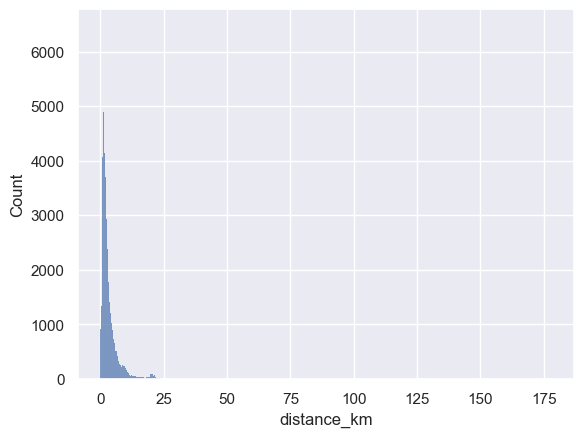

In [217]:
sns.histplot(X_train["distance_km"])

<Axes: xlabel='distance_km', ylabel='Count'>

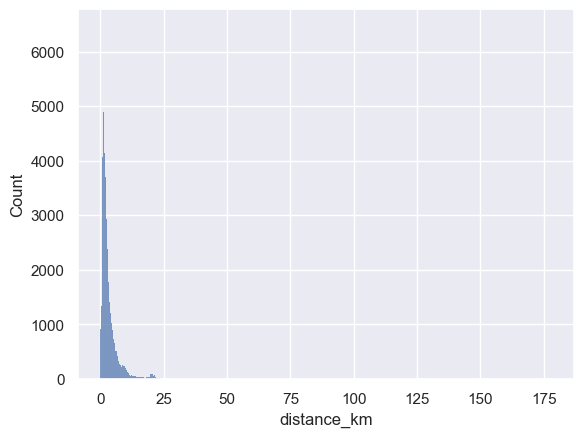

In [218]:
sns.histplot(X_train["distance_km"])

In [219]:
X_train.shape[0],X_test.shape[0]

(159955, 39989)

In [220]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [221]:
# crear un pipeline para la preprocesamiento y el modelo
pipeline = Pipeline([ 
    ('Linear', LinearRegression())  
])

# ajustar el modelo a los datos de entrenamiento
pipeline.fit(X_train_scaled, y_train)

# hacer predicciones con el conjunto de prueba
y_pred = pipeline.predict(X_test_scaled)

In [226]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


MAE: 2.83
RMSE: 6.66
R²: 0.55
